In [0]:
!pip install --upgrade pip
!pip install rpy2==3.4.5


     |████████████████████████████████| 2.1 MB 6.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Created wheel for rpy2: filename=rpy2-3.4.5-cp39-cp39-linux_x86_64.whl size=297800 sha256=22266d24ba2931333ffed6d66aa93d6c6d1da44389a5f1bd7d35707a8482bfc1
  Stored in directory: /root/.cache/pip/wheels/36/d1/63/882c1f63d21bcf817b7db960b9536a747d4258daeaace0edd4
Successfully built rpy2


In [0]:
import requests
from base64 import b64encode
import pandas as pd
import re
%load_ext rpy2.ipython
from rpy2.robjects.packages import importr
#import rpy2

import warnings
warnings.filterwarnings('ignore')


###Extração dos Dados

In [0]:
import base64

def codificar(nome_empresa):
    texto = f'{{"language":"pt-br","pageNum":1,"pageSize":20,"tradingName":"{nome_empresa}"}}'
    codigo_base64 = base64.b64encode(texto.encode()).decode()
    return codigo_base64    



In [0]:
def proventos (nome_empresa):


    string	= codificar(nome_empresa)

    r = requests.get('https://sistemaswebb3-listados.b3.com.br/listedCompaniesProxy/CompanyCall/GetListedCashDividends/' +
    string)

    return r.json()


In [0]:
def get_names():
  get_name = requests.get(r'https://sistemaswebb3-listados.b3.com.br/indexProxy/indexCall/GetPortfolioDay/eyJsYW5ndWFnZSI6InB0LWJyIiwicGFnZU51bWJlciI6MSwicGFnZVNpemUiOjEyMCwiaW5kZXgiOiJJQk9WIiwic2VnbWVudCI6IjEifQ==')
  dados = get_name.json()['results']
  names = [d['asset'] for d in dados]

  return names






In [0]:
def get_dataframes():
  names = get_names()
  list_dataframes = []
  for i in names:
      list_dataframes.append(pd.DataFrame(proventos(i)['results']))

  return list_dataframes



###Transformação dos Dados

In [0]:
def get_df():
  df = pd.DataFrame()
  list_dataframes =  get_dataframes()
  for i in list_dataframes:
      df = pd.concat([df, i])
  return  df

In [0]:
def slice_df():
  df = get_df()
  df_dividendo = df.query('corporateAction == "DIVIDENDO"')
  df_capital = df.query('corporateAction == "JRS CAP PROPRIO"')
  df_total = pd.concat([df_dividendo, df_capital])
  return df_dividendo, df_capital, df_total

In [0]:
df_dividendo, df_capital, df_total = slice_df()

###Refinamento e Exportação dos Dados

In [0]:
import pandas as pd
class Dataframe(object):

  def __init__(self, df, name):
    self.name = name
    self.df = df

  def slice (self):
    self.df = self.df[['dateApproval' , 'corporateActionPrice']]

  def drop(self):
    self.df.dropna(inplace=True)

  def transform_date(self):
    self.df['dateApproval'] = pd.to_datetime(self.df['dateApproval'], format='%d/%m/%Y')

  def sort(self):
    self.df = self.df.sort_values(by=['dateApproval'], ascending=False)


  def replace(self):
    self.df['corporateActionPrice'] = self.df.loc[:,'corporateActionPrice'].apply(lambda x: float(x.split()[0].replace(',', '.')))


  def rename (self):
    self.df = self.df.rename(columns={'dateApproval': 'date', 'corporateActionPrice': 'value'})


  def divide (self):
    self.df['value'] = 1 / self.df['value']

  def reset_index(self):
    self.df.reset_index(inplace=True)
    self.df.drop('index', axis=1, inplace=True)
    #print(self.df)



  def save_csv(self):
    self.df.to_csv(self.name +'.csv', index=False)



def main(df, name):
  df = Dataframe(df, name)
  df.slice()
  df.drop()
  df.transform_date()
  df.sort()
  df.replace()
  df.rename()
  df.divide()
  df.reset_index()
  df.drop()
  df.save_csv()





if __name__ == '__main__':
    #df_dividendo, df_capital, df_total = slice_df()
    main(df_total, 'df_total')
    main(df_capital, 'df_capital')
    main(df_dividendo, 'df_dividendo')


           date     value
0    2023-10-25  0.772454
1    2023-10-16  1.743688
2    2023-10-16  1.708739
3    2023-10-11  1.441527
4    2023-10-10  4.977081
...         ...       ...
7763 1996-02-28  0.286104
7764 1996-02-14  0.128477
7765 1996-02-14  0.099536
7766 1996-02-12  1.050596
7767 1996-02-12  1.157738

[7768 rows x 2 columns]
           date     value
0    2023-10-16  1.743688
1    2023-10-16  1.708739
2    2023-10-10  0.890165
3    2023-10-10  0.895025
4    2023-10-10  0.889700
...         ...       ...
4429 1997-04-25  0.330949
4430 1997-04-25  0.330949
4431 1997-04-25  0.324744
4432 1997-04-10  0.504762
4433 1997-04-10  0.596269

[4434 rows x 2 columns]
           date     value
0    2023-10-25  0.772454
1    2023-10-11  1.441527
2    2023-10-10  2.637966
3    2023-10-10  2.622277
4    2023-10-10  2.623646
...         ...       ...
3329 1996-02-28  0.310627
3330 1996-02-14  0.128477
3331 1996-02-14  0.099536
3332 1996-02-12  1.157738
3333 1996-02-12  1.050596

[3334 rows x 

###Etapa de Machine Learning e Criação de Gráficos 

In [0]:
%%R

devtools::install_github("itamarcaspi/psymonitor", force = FALSE)


install.packages("lubridate", repos = "http://cran.rstudio.com")
install.packages("gridExtra", repos = "http://cran.rstudio.com")




(as ‘lib’ is unspecified)







	‘/tmp/RtmpiYeNtI/downloaded_packages’



* checking for file ‘/tmp/RtmpiYeNtI/remotes3cc50898276/itamarcaspi-psymonitor-153ea33/DESCRIPTION’ ... OK
* preparing ‘psymonitor’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘psymonitor_0.0.2.9000.tar.gz’



(as ‘lib’ is unspecified)

(as ‘lib’ is unspecified)







	‘/tmp/RtmpiYeNtI/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpiYeNtI/downloaded_packages’



In [0]:
%%R
library(psymonitor)
data(spread)

In [0]:
%%R
# trecho de código adaptado de Phillips & Shi(2020)
calculate <- function(spread, name){

    library(psymonitor)
    library(gridExtra)
    library(grid)
    library(gtable)
    data(spread)

    #spread  <- spread[1:150, ]


    y           <- spread$value #1/div
    spread$date <- as.Date(spread$date)
    obs         <- length(y)
    swindow0    <- floor(obs * (0.01 + 1.8 / sqrt(obs))) # set minimal window size
    IC          <- 2  # use BIC to select the number of lags
    adflag      <- 6  # set the maximum nuber of lags to 6
    yr          <- 2
    Tb          <- 12*yr + swindow0 - 1  # Set the control sample size
    nboot       <- 99  # set the number of replications for the bootstrap

    bsadf <- PSY(y, swindow0 = swindow0, IC = IC, adflag = adflag)  # estimate the PSY test statistics sequence
    quantilesBsadf <- cvPSYwmboot(y, swindow0 = swindow0, IC = IC, adflag = adflag, Tb = Tb, nboot = 2, nCores = 2) # simulate critical values via wild bootstrap. Note that the number of cores is arbitrarily set to 2.

    dim         <- obs - swindow0 + 1
    date        <- spread$date[swindow0:obs]
    quantile95  <- quantilesBsadf %*% matrix(1, nrow = 1, ncol = dim)
    ind95       <- (bsadf > t(quantile95[2, ])) * 1
    periods     <- locate(ind95, date)  # Locate crisis periods
    crisisDates <- disp(periods, obs)  #generate table that holds crisis periods


    titulo <- textGrob(sprintf("Episódios de Crises das Empresas Listadas na B3:\n %s", name), gp = gpar(fontsize = 15, fontface = "bold"))
    tamanho_topo <- unit(2, "in")  # Neste exemplo, usamos 2 polegadas


    tabela      <- tableGrob(crisisDates, theme = ttheme_default(base_size = 40))  
    grid.arrange(titulo, tabela, top = tamanho_topo)
    return(ind95)

}

In [0]:
%%R
# trecho de código adaptado de Phillips & Shi(2020)
chart <- function(ind95, spread, name) {

   

    y        <- spread$value #1/div
    spread$date     <- as.Date(spread$date)
    obs      <- length(y)
    swindow0 <- floor(obs * (0.01 + 1.8 / sqrt(obs))) 
    date         <- spread$date[swindow0:obs]

    plot(date,y[swindow0:obs],xlim=c(min(date),max(date)), main = sprintf("Episódios de Crises das Empresas Listadas na B3:\n %s", name), ylim=c(0.1,8), type='l',lwd=3, xlab = "", ylab = "")
    for(i in 1:length(date)){
        if (ind95[i]==1){abline(v=date[i],col=3)}
    }
    points(date,y[swindow0:obs],type='l')
    box(lty=1)
}

In [0]:
%%R
obs_data <- function(spread, name) {
    library(lubridate)
    library(gridExtra)

    spread$date <- as.Date(spread$date)
    tabela_frequencia <- table(format(spread$date, "%Y"))
    df_tabela <- as.data.frame(tabela_frequencia)

    colnames(df_tabela) <- c("Ano", "Contagem") 

    titulo <- textGrob(sprintf("Contagem de Observações por Ano na B3:\n %s", name), gp = gpar(fontsize = 15, fontface = "bold"))


    n <- nrow(df_tabela)
    n_colunas <- 2
    n_linhas <- ceiling(n / n_colunas)
    metade1 <- df_tabela[1:n_linhas, ]
    metade2 <- df_tabela[(n_linhas + 1):n, ]

    tabela1 <- tableGrob(metade1, theme = ttheme_default(base_size = 17))  
    tabela2 <- tableGrob(metade2, theme = ttheme_default(base_size = 17))  

    tamanho_topo <- unit(2, "in")  

    
    grid.arrange(titulo,
                 arrangeGrob(tabela1, tabela2, ncol = n_colunas),
                 top = tamanho_topo,
                 heights = c(0.1, 0.9))
}



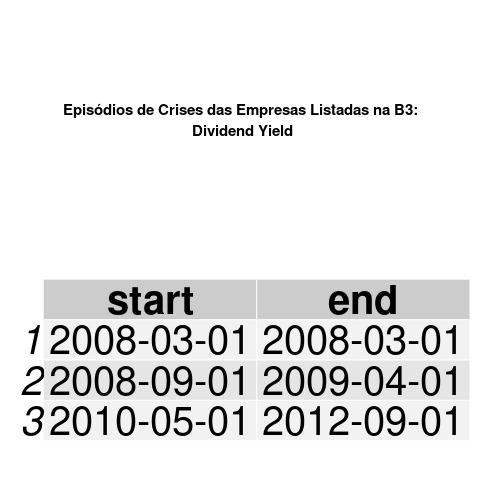

In [0]:
%%R
spread <- read.csv("df_dividendo.csv")
name <- "Dividend Yield"
ind95 <- calculate(spread, name)

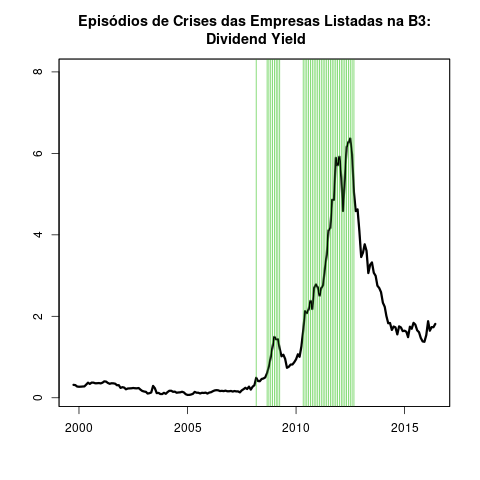

In [0]:
%%R
chart(ind95, spread, name="Dividend Yield")

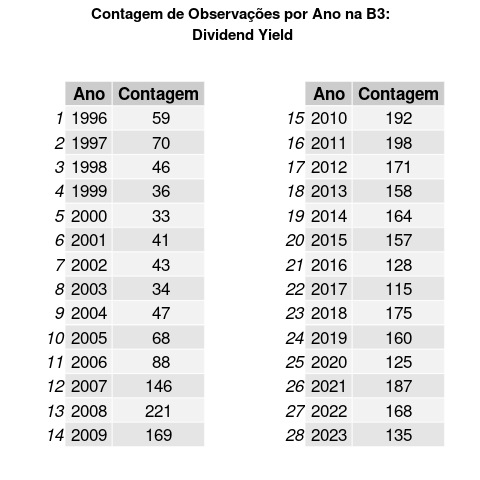

In [0]:
%%R
spread <- read.csv("df_dividendo.csv")
obs_data(spread, name)

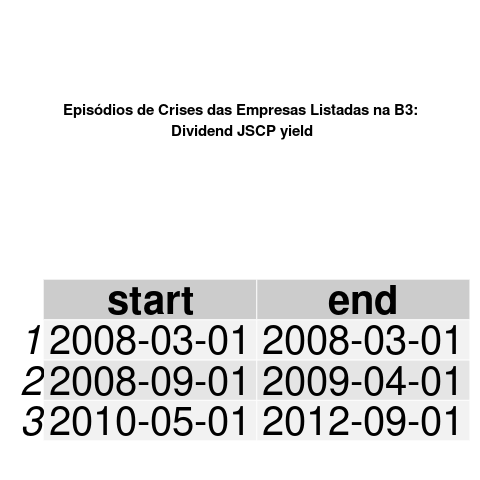

In [0]:
%%R
spread <- read.csv("df_capital.csv")
name <- "Dividend JSCP yield"
ind95 <- calculate(spread, name)


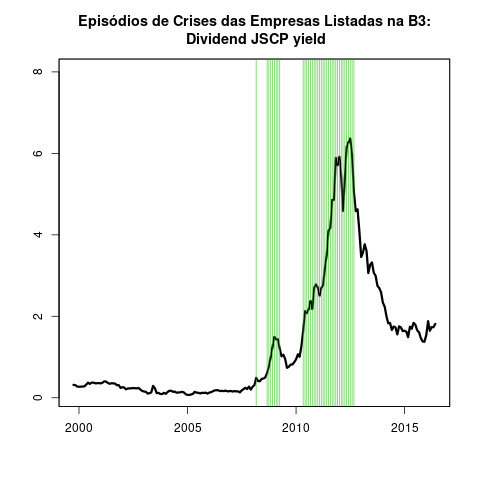

In [0]:
%%R
name <- "Dividend JSCP yield"
chart(ind95, spread, name)


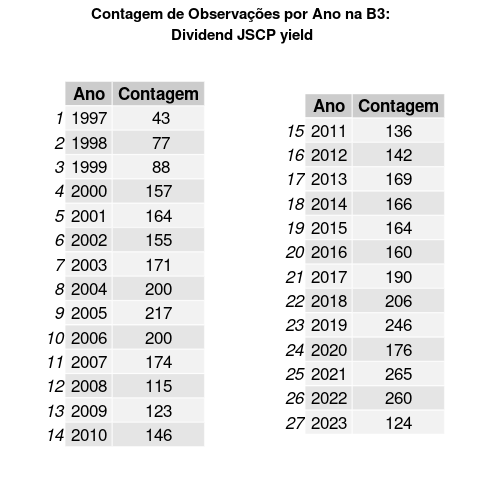

In [0]:
%%R
spread <- read.csv("df_capital.csv")
obs_data(spread, name)

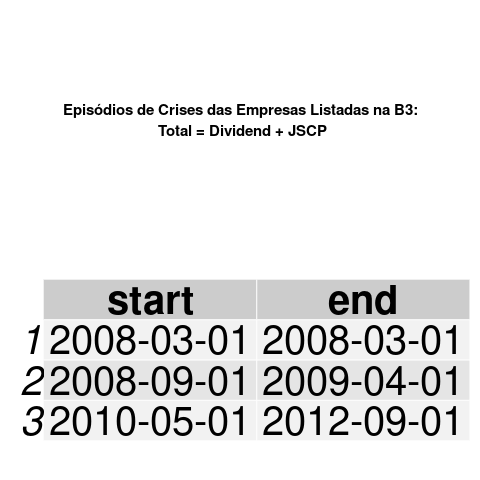

In [0]:
%%R
spread <- read.csv("df_total.csv")
name <- "Total = Dividend + JSCP"
ind95 <- calculate(spread, name)

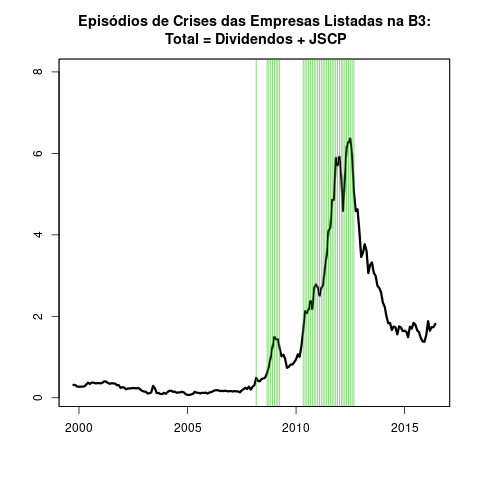

In [0]:
%%R
name <- "Total = Dividendos + JSCP"
chart(ind95, spread, name)


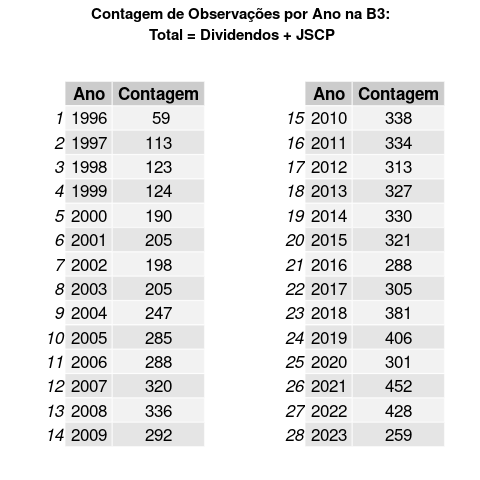

In [0]:
%%R
spread <- read.csv("df_total.csv")
obs_data(spread, name)